## Soft margin SVM
Soft margin SVM is a branch of SVM (Support Vector Machines) that allows the model to make some level of misclassifications as to make the decision boundary (SOFTER)

Specifically, it aims to solve the following dual problem 

$$
max \space \sum_{i}\alpha_i - \frac{1}{2}\sum_i \sum_j y^{(i)}y^{(j)}a_ia_j<x^{(i)}, x^{(j)}> \\
s.t. \space C \ge \alpha_i \ge 0 , \sum_i y^{(i)}\alpha_i = 0
$$

With the following KKT conditions

$$
a_i = 0 \Rightarrow y^{(i)}(w^Tx^{(i)}+b) \ge 1 \\ 
a_i = C \Rightarrow y^{(i)}(w^Tx^{(i)}+b) \le 1 \\ 
C \ge a_i \ge 0 \Rightarrow y^{(i)}(w^Tx^{(i)}+b) = 1
$$

Along side with kernel trick, SMO is one of the powerful tools that can do so. 


## Implementation

### Required Values
- **point** corresponds to the training data $x_i$
- **target** corresponds to the training outputs $y_i$
- **C** is inversely proportional to the amount of mistakes we can afford. This depends on the scale of the problem. Mostly it’s set from $.01 \to100$
- **tol** is the amount of tolerance we will have for the KKT conditions.
- **prog_margin** is the padding we will employ for the calculation of $L$ and $H$ as to not make them equal. This will also serve as our margin in determining whether the two langrange multiplier has made any positive progress.
- **clip_padding** is the padding we will apply on the constraint $C \ge a_i \ge 0$ where we wil clip $a_i$ to either $C$ or $0$ if it’s within that padding

☝🏻 tol, prog_margin and clip_padding are mostly set to $1e^-3$ to $1e^-5$

In [9]:
import numpy as np
import math

np.random.seed(690420)

M: int = 100
D: int = 1
point = np.random.normal(size=(M, D), loc=0, scale=10).astype(np.float64)
target = np.random.choice([-1, 1], size=(M), replace=True)
c: np.float64 = 5
tol: np.float64 = 0.0001
prog_margin: np.float64 = 0.00001
clip_padding: np.float64 = 0.000000001
max_ch: int = 600

### Kernel Function
Function responsible for the kernel trick

For gaussian Kernels we use the following 
$$
K(x ,z ) = exp(-\frac{||x-z||^2}{2\sigma})
$$

This can be sped up from the fact that $||x-z||^2 = x * x - 2x*z + z *z $

We can cache the dot product of vector to itself. We can also store the dot product of every 2 possible pair! but this may take a lot of memory

In [10]:
def conv_1d(M: int, i: int, j: int):
    low:  int = np.min(i, j)
    hi :  int = np.max(i, j)

    '''
    This function is responsible for converting a 2D position to 1D.
    This is because the cache is in 1 Dimension. 
    It's a trick that allows us to produce cache for position i, j without 
    creating a duplicate (i.e. j, i). This allows us to half the memory spent 
    for caching which is especially useful when data is 10,000 and above
    '''
    return ((low*(2*M - low - 1) + (2 * hi))/2)

def initialize_kernels(size: int):
    cache_len: np.float64 = (size * (size - 1))/2
    cache = np.zeros(shape=(cache_len), dtype=np.float64)

    for i in range(size):
        for j in range(size):
            cache[conv_1d(i, j)] = kernel_gaussian(point[i], point[j])

    return cache, cache_len

def kernel_gaussian(x: np.float32, z: np.array, sigma=1) -> float:
    return np.exp((-(np.dot(z, z) - 2*np.dot(x, z) + np.dot(x, x))/(2 * sigma ** 2)))

kernel_g_cache, cache_len = initialize_kernels(M)

TypeError: expected a sequence of integers or a single integer, got '4950.0'

### Helper Functions

In [ ]:


def compute_svm_err(x: int, alphs: np.float64, err_cache: np.float64, b: np.float64) -> np.float64:
    fx: np.float64 = obj_x(point[x], alphs, b, cache_val=x)
    err_cache[x] = fx - target[x]
    return err_cache[x]     

def obj_x(val: np.float64, alphs: np.float64, b: np.float64, cache_val: int = -1) -> np.float64:
    fx: np.float64 = b
    alphs_zero: np.float64 = np.where(alphs != 0)[0]
    
    for i in alphs_zero:
        K = kernel_g_cache[conv_1d(i, cache_val)] if cache_val > -1 else kernel_gaussian(point[i], val)
        fx += alphs[i] * target[i] * K
        
    return fx

def accuracy(alphs: np.float64, b: np.float64) -> np.float64:
    correct: float = 0.0

    for i in range(M):
        fx: np.float64 = obj_x(point[i], alphs, b, cache_val=i)
        correct += (target[i]*fx > 0)
    
    return correct / M

def predict(alphs: np.float64, b: np.float64, x: np.float64, new: bool = False) -> np.float64:
    res: np.float64 = np.zeros(shape=(len(x)), dtype=np.float64)

    for i in range(len(x)):
        fx: np.float64 = obj_x(x[i], alphs, b, cache_val=(-1 if new else i))
        res[i] = fx
    
    return res

### Step Function
Lastly the function that takes a coordinate ascent step given the two multipliers

In [ ]:
def take_step(i1: int, i2: int, alphs: np.float64, non_bound_alphs: np.int64, err_cache: np.float64, B: np.float64, log: bool=False) -> bool:
    #print(f"Taking step for {i1} and {i2}")
    if (i1 == i2):
        #print("Positions equal")
        return 0
    
    non_bound: bool = alphs[i1] != 0 and alphs[i1] != c
    b: np.float64 = B[0]

    E1: np.float64 = err_cache[i1] if non_bound else compute_svm_err(i1, alphs, err_cache, b)
    E2: np.float64 = err_cache[i2] 
    y1: int = target[i1]
    y2: int = target[i2]
    alph1: np.float64 = alphs[i1]
    alph2: np.float64 = alphs[i2]
    s: int = y1 * y2

    # Computation for L and H
    if (y1 == y2):
        L: np.float64 = max(0, alph1 + alph2 - c)
        H: np.float64 = min(c, alph1 + alph2)
    else:
        L: np.float64 = max(0, alph2 - alph1)
        H: np.float64 = min(c, c + alph2 - alph1)

    if (L == H):
        #print("L and H equal")
        return 0
    
    K11: np.float64 = kernel_g_cache[conv_1d(cache_len, i1, i1)]
    K22: np.float64 = kernel_g_cache[conv_1d(cache_len, i2, i2)]
    K12: np.float64 = kernel_g_cache[conv_1d(cache_len, i1, i2)]
    eta: np.float64 = K11 + K22 - 2*K12

    if (eta > 0):
        alph2_new: np.float64 = (alph2) + (y2*(E1 - E2)/eta)
        if (alph2_new <= L):
            alph2_new = L
        elif (alph2_new >= H):
            alph2_new = H
    else:
        v1: np.float64 = E1 - alph1*y1*K11 - alph2*y2*K12
        v2: np.float64 = E2 - alph1*y1*K12 - alph2*y2*K22
        zeta: np.float64 = alph1*y1 + alph2*y2
        Lobj: np.float64 = L*(1-s) + zeta*s*L*K11 - (.05*(L**2)*(K11 + K22)) - (zeta - s*L)*s*L*K12 + (v1 - v2)*y2*L
        Hobj: np.float64 = H*(1-s) + zeta*s*H*K11 - (.05*(H**2)*(K11 + K22)) - (zeta - s*H)*s*H*K12 + (v1 - v2)*y2*H

        if (Lobj < Hobj - prog_margin):
            alph2_new: np.float64 = L
        elif (Lobj > Hobj + prog_margin):
            alph2_new: np.float64 = H    
        else:
            alph2_new: np.float64 = alph2

    # clip
    if (alph2_new < clip_padding):
        alph2_new = 0
    elif (alph2_new > c - clip_padding):
        alph2_new = c
        
    if (abs(alph2_new - alph2) < (prog_margin * (alph2_new + alph2 + prog_margin))):
        #print("Bad progress")
        return 0
    
    alph1_new: np.float64 = alph1 + (s*(alph2 - alph2_new))

    # update tresholds
    b1: np.float64 = b - E1 - y1*K11*(alph1_new - alph1) - y2*K12*(alph2_new - alph2)
    b2: np.float64 = b - E2 - y1*K12*(alph1_new - alph1) - y2*K22*(alph2_new - alph2)
    
    if (alph1_new < c and alph1_new > 0):
        B[0] = b1
    elif (alph2_new < c and alph2_new > 0):
        B[0] = b2
    else:
        B[0] = (b1 + b2)/2

    # update err_cache
    err_cache[i1], err_cache[i2] = 0, 0
    for i in non_bound_alphs:
        if (i == i1 or i == i2):
            continue
        
        K1k: np.float64 = kernel_g_cache[conv_1d(cache_len, i, i1)]
        K2k: np.float64 = kernel_g_cache[conv_1d(cache_len, i, i2)]

        err_cache[i] += y1*K1k*(alph1_new - alph1) + y2*K2k*(alph2_new - alph2) + B[0] - b
    
    # update alphs
    alphs[i1], alphs[i2] = alph1_new, alph2_new
    
    if (log):
        print(f"======= Step successful for {i1} and {i2} =======")
        print(f"a1: {alph1} -> {alph1_new} | a2: {alph2} -> {alph2_new}")
        print(f"b: {b} -> {B[0]}")
        print(f"err_cache: {err_cache}")
        print("==================================================")

    return 1

### Examine Alpha Function
The second function which is responsible for checking the first langrange multiplier that is chosen and responsible for picking the next langrange multiplier

In [ ]:
def examine_a(i2: int, alphs: np.array, non_bound: bool, non_bound_alphs: np.int64, err_cache: np.array, B: np.float64) -> bool:
    non_b_len: int = len(non_bound_alphs)
    b: np.float64 = B[0]
    E2: np.float64 = err_cache[i2] if non_bound else compute_svm_err(i2, alphs, err_cache, b)
    r2: np.float64 = E2 * target[i2]
    alph2: np.float64 = alphs[i2]

    if ((r2 < -tol and alph2 < c) or (r2 > tol and alph2 > 0)):
        #print("choosing second multipier")
        if (non_b_len > 1):
            # Second heuristic using optimal err for step estimation
            positive: bool = (err_cache[i2] >= 0)
            i1: int = i2

            for i in non_bound_alphs:
                if (i == i2):
                    continue

                if (i1 == i2):
                    i1 = i
                elif (positive and err_cache[i] < err_cache[i1]):
                    i1 = i
                elif (not positive and err_cache[i] > err_cache[i1]):
                    i1 = i

            if (take_step(i1, i2, alphs, non_bound_alphs, err_cache, B)):
                return 1

        # take non-bound alps
        if non_b_len > 0:
            start: int = np.random.randint(size=(1), low=0, high=non_b_len)[0]
            for i in range(non_b_len):
                pos: int = (start + i)%non_b_len
                if (take_step(non_bound_alphs[pos], i2, alphs, non_bound_alphs, err_cache, B)):
                    return 1
        
        # loop through entire training set
        start: int = np.random.randint(size=(1), low=0, high=M)[0]
        for i in range(M):
            if (take_step((start + i)%M, i2, alphs, non_bound_alphs, err_cache, B)):
                return 1
    
    #print("already satisfy kkt conditions")
    return 0

### Train Function
The train function which is responsible for picking the first langrange multiplier from a set of langrange multipliers. It is also responsible for initializing the important variables

In [ ]:
def smo_train() -> dict:
    alphs: np.float64 = np.zeros(shape=(M), dtype=np.float64)
    err_cache: np.float64 = np.zeros(shape=(M), dtype=np.float64)
    B: np.float64 = np.array([0.], dtype=np.float64)

    examine_all: bool = True
    num_changed: int = 0
    total_iter: int = 0

    while num_changed > 0 or examine_all:
        #print("choosing first multiplier")
        if total_iter >= max_ch:
            break

        num_changed = 0 
        non_bound_alphs = np.where((alphs != 0) & (alphs != c))[0]

        if examine_all:
            for i in range(M):
                num_changed += examine_a(i, alphs, False, non_bound_alphs, err_cache, B)
        else:
            for i in non_bound_alphs:
                num_changed += examine_a(i, alphs, True, non_bound_alphs, err_cache, B)

        if examine_all:
            examine_all = False
        elif num_changed == 0:
            examine_all = True

        total_iter += 1
        print("Total iterations: ", total_iter)

    #print(err_cache)
    return {"alphs": alphs, "err_cache": err_cache, "b": B[0]}

### Test
You can test the result here

In [ ]:
import matplotlib.pyplot as plt

'''
x = [(0.1+ (i * 0.1)) for i in range(1, 10)]
y = []

for i in range(len(x)):
    c = x[i]
    res = smo_train()
    y.append(accuracy(res["alphs"], res["b"]))
    
plt.xlabel("c")
plt.ylabel("average distance")
plt.scatter(x, y)
'''
'''
res = smo_train()
print(accuracy(res['alphs'], res['b']))
'''

"\nres = smo_train()\nprint(accuracy(res['alphs'], res['b']))\n"

## DEMO
This Demo only works in 2 Dimensions, hence the number of parameters are at most 2
Also, this overwrites the global variables above because the format of the code above is not object oriented (for note taking purposes)

n = number of points per classification (i.e. M/2)

Change n to change the number of points in the plot

You can treat the code below as a separate code, it's just created for visualization

bias = -0.027201691524776618
training data error rate = 0.00


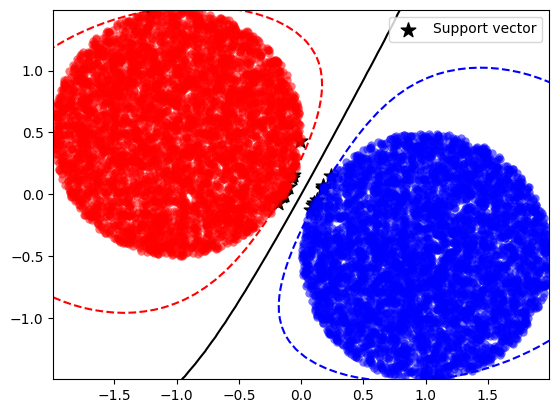

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

n = 5000
M = n*2     # Overwrites the above M to make this wor
D = 2       # Ensures dimensions are 2

def gen_circle(n, center_x=0, center_y=0, radius=1, label=0):
    alpha = 2 * np.pi * np.random.rand(n)
    r = radius * np.sqrt(np.random.rand(n))
    x = r * np.cos(alpha) + center_x
    y = r * np.sin(alpha) + center_y
    label = np.ones(n) * label
    return [x, y, label]

C0 = gen_circle(n, center_x=-1, center_y=.5, radius=1, label=1)
C1 = gen_circle(n, center_x=1, center_y=-.5, radius=1, label=-1)

x0 = np.append(C0[0], C1[0])
x1 = np.append(C0[1], C1[1])

X = np.c_[x0, x1]
Y = np.append(C0[2], C1[2])

scaler = StandardScaler()
train_x = scaler.fit_transform(X)

# Main function
point = train_x
target = Y
kernel_g_cache, cache_len = initialize_kernels(M) # Reinitializes the kernels above
model = smo_train()

# Prediction in vector
train_y = predict(model['alphs'], model['b'], point, new=False)
#print('support vector: {} / {}'\
    #.format(len(model['alphs'][model['alphs'] > 1e-5]), len(model['alphs'])))

# Gathers the support vectors (non-zero alpha)
sv_threshold = 0
sv_idx = []
for idx, alpha in enumerate(model['alphs']):
    if alpha > sv_threshold:
        #print('index = {}, alpha = {:.3f}, predict y={:.3f}'\
            #.format(idx, alpha, train_y[idx]))
        
        sv_idx.append(idx)

# Threshold
print(f'bias = {model["b"]}')
# Error rate
train_y_sign = np.sign(train_y)
error_rate = np.mean(train_y_sign != target)
print('training data error rate = {:.2f}'.format(error_rate))

# Draw the Plot
plt.plot(C0[0], C0[1], 'o', markerfacecolor='r', markeredgecolor='None', alpha=0.55)
plt.plot(C1[0], C1[1], 'o', markerfacecolor='b', markeredgecolor='None', alpha=0.55)

resolution = 50
dx = np.linspace(X[:, 0].min(), X[:, 0].max(), resolution)
dy = np.linspace(X[:, 1].min(), X[:, 1].max(), resolution)
dx, dy = np.meshgrid(dx, dy)
plot_x = np.c_[dx.flatten(), dy.flatten()]

transformed_plot_x = scaler.transform(plot_x)
dz = predict(model['alphs'], model['b'], transformed_plot_x, True)
dz = dz.reshape(dx.shape)

plt.contour(dx, dy, dz, alpha=1, colors=('b', 'k', 'r'), \
            levels=(-1, 0, 1), linestyles = ('--', '-', '--'))

label_cnt = 0
for i in sv_idx:
    if label_cnt == 0:
        plt.scatter(X[i, 0], X[i, 1], marker='*', color='k', \
                    s=120, label='Support vector')
        label_cnt += 1
        continue

    plt.scatter(X[i, 0], X[i, 1], marker='*', color='k', s=120)

plt.legend()
plt.show()
